In [ ]:
import matplotlib.pyplot as plt



class Graphes:

    @staticmethod
    def accuracy_loss_graphe(historique):
        # Affichage accuracy - loss
        fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
        axs = axs.flatten()
        axs[0].plot(historique.history["accuracy"], label='Accuracy Train')
        axs[0].plot(historique.history["val_accuracy"], label='Accuracy Test')
        axs[0].set_title(f"Evolution de l'accuracy")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()

        axs[1].plot(historique.history["loss"], label='Loss Train')
        axs[1].plot(historique.history["val_loss"], label='Loss Test')
        axs[1].set_title(f"Evolution de la perte")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        plt.show()

In [ ]:
import numpy as np
import random
from PIL import Image

class ImageGenerator:

    @staticmethod
    def create_imperfect_image(image, image_size=(56, 56)):

        new_image = np.ones((*image_size, image.shape[2]), dtype=np.uint8)

        max_offset = image_size[0] - image.shape[0]
        random_x = random.randint(0, max_offset)
        random_y = random.randint(0, max_offset)

        new_image[random_x:random_x+image.shape[0], random_y:random_y+image.shape[1], :] = image
        return new_image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generation_propre(X, y, nb=10000):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,   # Décalage horizontal
        height_shift_range=0.15,  # Décalage vertical
        zoom_range=0.2,          # Zoom
    )

    new_images_generator = datagen.flow(X, batch_size=1, shuffle=False)

    X_new = X.tolist()
    y_new = y.tolist()
    for i in range(nb):
        img = next(new_images_generator)[0]
        X_new.append(img.tolist())
        y_new.append(y[i].tolist())

        if i < 1:
          plt.figure()
          plt.imshow(img, cmap="grey")
          plt.axis('off')
          plt.show()
    return X, y


In [ ]:
# Création image 56 x 56 avec chiffre positioné aléatoirement
# L'image est ensuite redimensionnée -> 28 x 28

def generation_2(X, y, nb=10000):
    new_images = X.tolist()
    new_images_label = y.tolist()

    for i in range(nb):
        imperfect_image = ImageGenerator.create_imperfect_image(X[i])

        # imperfect_image = tf.image.resize(imperfect_image, (28, 28))
        imperfect_image = tf.expand_dims(imperfect_image, axis=0)
        imperfect_image = tf.nn.max_pool2d(imperfect_image, ksize=2, strides=2, padding="VALID")

        imperfect_image = imperfect_image.numpy().reshape(28, 28, 1)


        new_images.append(imperfect_image.tolist())
        new_images_label.append(y[i].tolist())

        if i < 1:
          plt.figure()
          plt.imshow(imperfect_image, cmap="grey")
          plt.axis('off')
          plt.show()

    new_images = np.array(new_images)
    new_images_label = np.array(new_images_label)

    return new_images, new_images_label

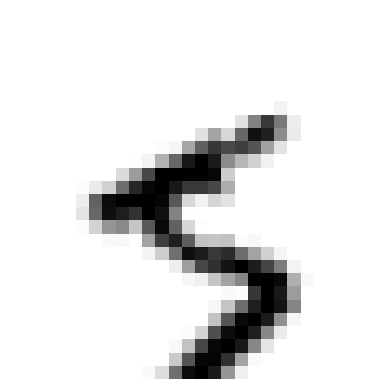

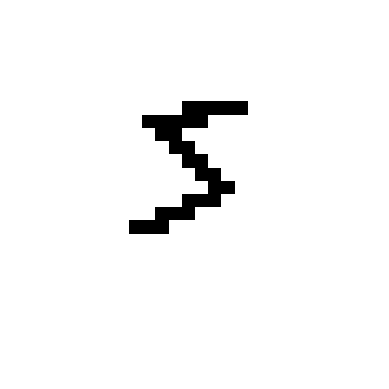

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten


# Charger les données MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalisation
x_train = x_train / 255.0
x_test = x_test / 255.0

# Inversion
x_train = 1 - x_train
x_test = 1 - x_test

x_train, y_train = generation_propre(x_train, y_train)
x_train, y_train = generation_2(x_train, y_train)


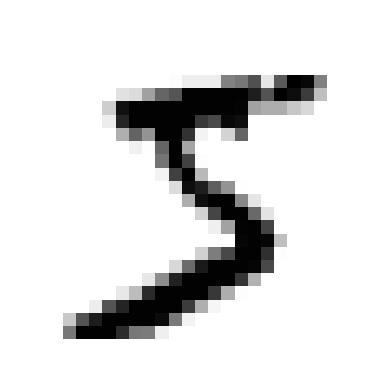

In [ ]:
# Apercu dataset
for i in range(1):
    plt.figure()
    plt.imshow(x_train[i], cmap="grey")
    plt.axis('off')
    plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, Conv2D, MaxPooling2D, Flatten, LSTM, Reshape, BatchNormalization, Bidirectional, GRU, AveragePooling2D
from sklearn.preprocessing import label_binarize
from tensorflow.keras.optimizers import Adam, AdamW
from PIL import Image


model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=2),
    Dropout(0.3),

    Reshape((-1, 64)),
    Bidirectional(GRU(128, activation='tanh')),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, activation="softmax")
])
optimizer = Adam(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Entrainement
historique = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.6764 - loss: 1.0482 - val_accuracy: 0.9744 - val_loss: 0.0763
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9484 - loss: 0.1659 - val_accuracy: 0.9891 - val_loss: 0.0371
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9613 - loss: 0.1266 - val_accuracy: 0.9877 - val_loss: 0.0430
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9665 - loss: 0.1098 - val_accuracy: 0.9900 - val_loss: 0.0285
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9709 - loss: 0.0971 - val_accuracy: 0.9835 - val_loss: 0.0502
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9744 - loss: 0.0870 - val_accuracy: 0.9936 - val_loss: 0.0212
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9769 - loss: 0.0763 - val_accuracy: 0.9920 - val_loss: 0.0257
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9760 -

In [ ]:
# Sauvegarde

model.save('mon_modele.h5')
from google.colab import files
files.download('mon_modele.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Charger
from tensorflow.keras.models import load_model

model = load_model("model/mon_modele.h5")

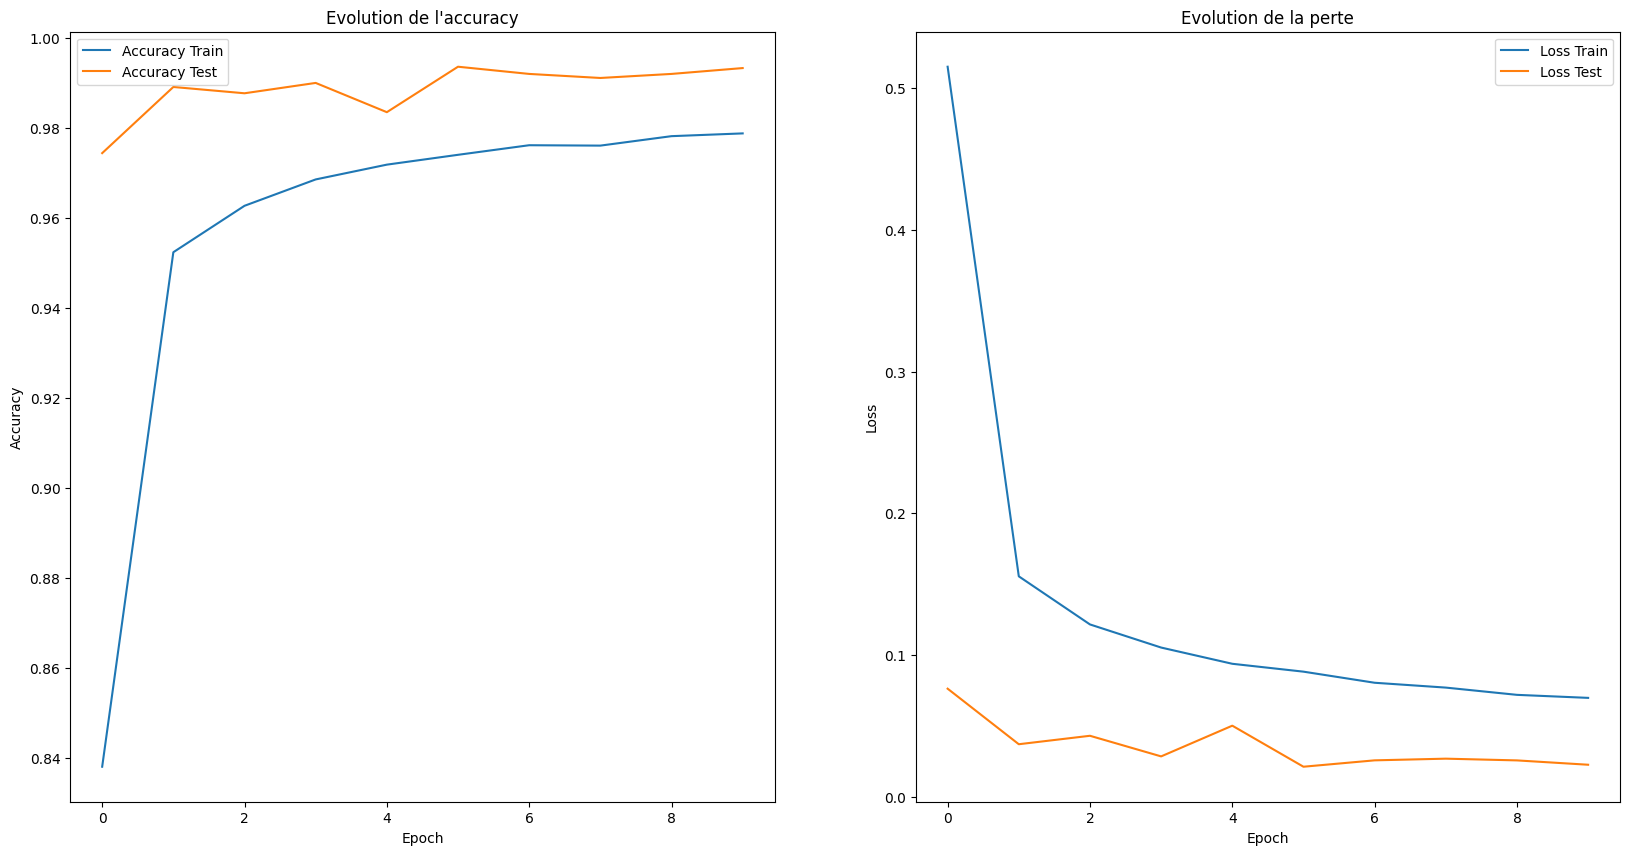

In [ ]:
Graphes.accuracy_loss_graphe(historique)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      1.00      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



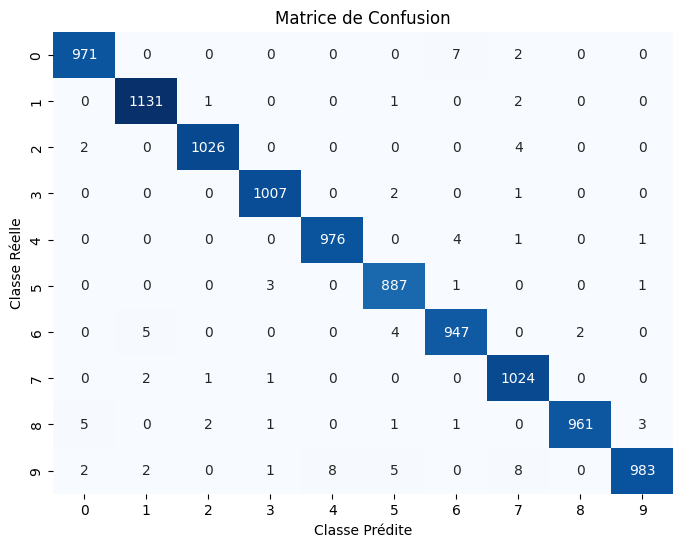

In [ ]:
# Stats et matrice de confusion
from sklearn.metrics import classification_report
import seaborn as sns

predictions = np.argmax(model.predict(x_test), axis=1)

print(classification_report(y_test, predictions, target_names=["0","1","2","3","4","5", "6","7", "8", "9"]))

confusion = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_1.png", format="png")
plt.show()


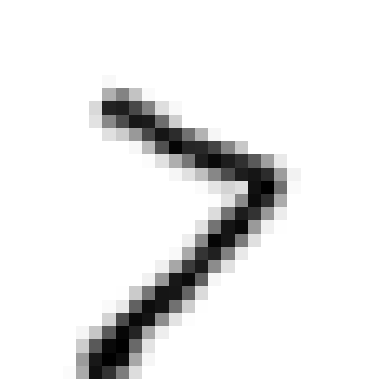

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



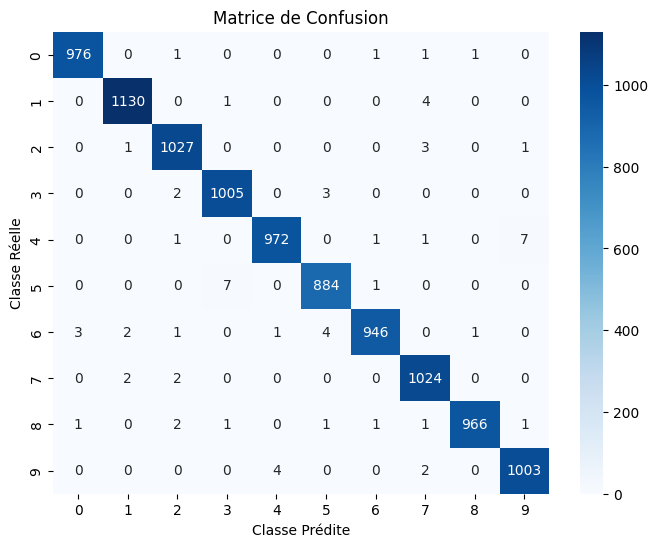

In [ ]:

new_images, new_images_label = generation_propre(x_test, y_test)



# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images), axis=1)

print(classification_report(new_images_label, new_pred))

confusion = confusion_matrix(new_images_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()



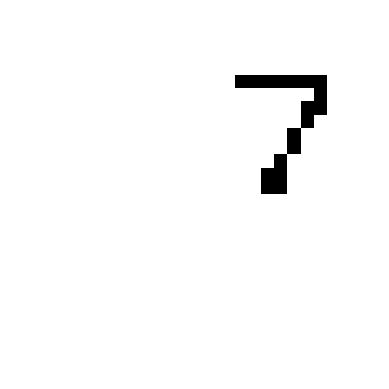

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1960
           1       0.99      0.99      0.99      2270
           2       0.97      0.98      0.98      2064
           3       0.96      0.97      0.97      2020
           4       0.97      0.95      0.96      1964
           5       0.97      0.97      0.97      1784
           6       0.99      0.97      0.98      1916
           7       0.95      0.98      0.96      2056
           8       0.97      0.95      0.96      1948
           9       0.94      0.96      0.95      2018

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



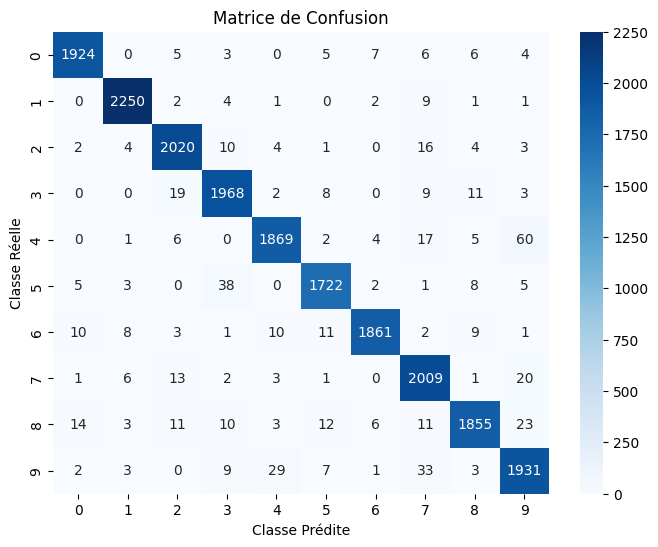

In [ ]:

new_images, new_images_label = generation_2(x_test, y_test)



# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images), axis=1)

print(classification_report(new_images_label, new_pred))

confusion = confusion_matrix(new_images_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()

